In [ ]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd


where_con = (
    "koi_disposition = 'CONFIRMED' AND "
    "koi_depth > 500 AND "
    "koi_model_snr > 100 AND "
    "koi_fpflag_nt = 0 AND "
    "koi_fpflag_ss = 0 AND "
    "koi_fpflag_co = 0 AND "
    "koi_fpflag_ec = 0"
)

where_fal = (
    "koi_disposition = 'FALSE POSITIVE' AND "
    "koi_fpflag_nt = 1"
)

# Step 1: Query CONFIRMED KOIs
confirmed = NasaExoplanetArchive.query_criteria(
    table="cumulative",
    select="kepid, koi_period, koi_duration, koi_time0bk, koi_depth, koi_model_snr, koi_disposition",
    where=where_con
).to_pandas().dropna()

# Step 2: Query FALSE POSITIVE KOIs
false_positives = NasaExoplanetArchive.query_criteria(
    table="cumulative",
    select="kepid, koi_period, koi_duration, koi_time0bk, koi_depth, koi_model_snr, koi_disposition",
    where = where_fal
).to_pandas().dropna()

# Step 3: Keep only one KOI per star (shortest period)
confirmed_unique = confirmed.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")
false_unique = false_positives.sort_values("koi_disposition").drop_duplicates(subset="kepid", keep="first")

# print(len(confirmed_unique))
# print(len(false_unique))

# Step 4: Remove overlapping kepids (same star in both groups)
overlap_kepids = set(confirmed_unique['kepid']).intersection(set(false_unique['kepid']))
# print(f"Number of overlapping kepids: {len(overlap_kepids)}")

confirmed_clean = confirmed_unique[~confirmed_unique['kepid'].isin(overlap_kepids)]
false_clean = false_unique[~false_unique['kepid'].isin(overlap_kepids)]

# Step 5: Sample 1000 unique stars from each class
confirmed_sample = confirmed_clean.sample(n=125, random_state=42)
false_sample = false_clean.sample(n=125, random_state=42)

# Step 6: Combine and shuffle
balanced_df = pd.concat([confirmed_sample, false_sample], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save to CSV
balanced_df.to_csv("midSet.csv", index=False)

# Final check
print(f"Final dataset size: {len(balanced_df)} rows")
print(f"Unique stars (kepid): {balanced_df['kepid'].nunique()}")
print(balanced_df.head())

In [5]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

df = pd.read_csv("midSet.csv")
kepids = df["kepid"].unique().tolist()
curve_length = 100
buffer_factor = 2

for kepid in kepids:
    if os.path.exists(f"curvesBig/{kepid}.npz"):
        print(f"File {kepid}.npz already exists. Skipping download.")
        continue  # Skip the rest of the loop if the file already exists
    print("Downloading: " + str(kepid))

    row = df.loc[df["kepid"] == kepid]
    period = row.iloc[0]["koi_period"]
    t0 = row.iloc[0]["koi_time0bk"]
    dur = row.iloc[0]["koi_duration"]
    fractional_duration = (dur / 24.0) / period

    lc = lk.search_lightcurve("KIC " + str(kepid), mission="Kepler", cadence = "long", limit = 10, author="Kepler").download_all().stitch()
    lc = lc.remove_nans()

    lc_flat = lc.flatten()

    lc_fold = lc_flat.fold(period, epoch_time=t0)

    window_half_width = fractional_duration * buffer_factor
    phase_mask = (lc_fold.phase > -(dur/24*0.5)*buffer_factor) & (lc_fold.phase < (dur/24*0.5)*buffer_factor)

    lc_zoom = lc_fold[phase_mask]
    print(len(lc_zoom))

    time = lc_zoom.time.value
    flux = lc_zoom.flux.value

    # Normalize time for interpolation
    t_min, t_max = time.min(), time.max()
    time_norm = (time - t_min) / (t_max - t_min)
    new_time_norm = np.linspace(0, 1, curve_length)

    # Interpolate flux to uniform time steps
    new_flux = np.interp(new_time_norm, time_norm, flux)
    new_time = np.linspace(t_min, t_max, curve_length)

    np.savez(f"curvesBig/{kepid}.npz", time=new_time, flux=new_flux)
    print("Downloaded: " + str(kepid))
    


File 6387887.npz already exists. Skipping download.
File 10748390.npz already exists. Skipping download.
File 7529266.npz already exists. Skipping download.
File 6061119.npz already exists. Skipping download.
File 12557548.npz already exists. Skipping download.
File 8374741.npz already exists. Skipping download.
File 4819158.npz already exists. Skipping download.
File 7031340.npz already exists. Skipping download.
File 11194032.npz already exists. Skipping download.
File 5966322.npz already exists. Skipping download.
File 8832676.npz already exists. Skipping download.
File 8179190.npz already exists. Skipping download.
File 7698701.npz already exists. Skipping download.
File 4483235.npz already exists. Skipping download.
File 9450647.npz already exists. Skipping download.
File 5560831.npz already exists. Skipping download.
File 8442463.npz already exists. Skipping download.
File 7366258.npz already exists. Skipping download.
File 5022900.npz already exists. Skipping download.
File 1102

4910
Downloaded: 2568971
Downloading: 11501492


205
Downloaded: 11501492
Downloading: 6205384


7515
Downloaded: 6205384
Downloading: 4067110


20242
Downloaded: 4067110
Downloading: 7024045


221
Downloaded: 7024045
Downloading: 6504954


183
Downloaded: 6504954
Downloading: 11414511


2889
Downloaded: 11414511
Downloading: 757450


771
Downloaded: 757450
Downloading: 3323887


700
Downloaded: 3323887
Downloading: 6678383


1212
Downloaded: 6678383
Downloading: 3866536


33522
Downloaded: 3866536
Downloading: 6421137


159
Downloaded: 6421137
Downloading: 6032920


216
Downloaded: 6032920
Downloading: 8309169


43
Downloaded: 8309169
Downloading: 7106438


60
Downloaded: 7106438
Downloading: 4073730


3738
Downloaded: 4073730
Downloading: 11442793


116
Downloaded: 11442793
Downloading: 10934313


2046
Downloaded: 10934313
Downloading: 10132552


38
Downloaded: 10132552
Downloading: 6541920


422
Downloaded: 6541920
Downloading: 3935914


4240
Downloaded: 3935914
Downloading: 7662209


633
Downloaded: 7662209
Downloading: 10351767


10436
Downloaded: 10351767
Downloading: 3858919


1423
Downloaded: 3858919
Downloading: 10910878


695
Downloaded: 10910878
Downloading: 8822216


1252
Downloaded: 8822216
Downloading: 5864975


225
Downloaded: 5864975
Downloading: 12470954


3761
Downloaded: 12470954
Downloading: 10614158


3258
Downloaded: 10614158
Downloading: 10489206


1409
Downloaded: 10489206
Downloading: 5112198


16209
Downloaded: 5112198
Downloading: 9941550


38
Downloaded: 9941550
Downloading: 8561063


1480
Downloaded: 8561063
Downloading: 9592831


8570
Downloaded: 9592831
Downloading: 3835670


1743
Downloaded: 3835670
Downloading: 4476423


1116
Downloaded: 4476423
Downloading: 8255887


2187
Downloaded: 8255887
Downloading: 8026752


3421
Downloaded: 8026752
Downloading: 7898352


178
Downloaded: 7898352
Downloading: 9631995


1587
Downloaded: 9631995
Downloading: 5476671


9787
Downloaded: 5476671
Downloading: 5031857
414
Downloaded: 5031857


In [ ]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

kepid = 3117046
df = pd.read_csv("midSet.csv")

row = df.loc[df["kepid"] == kepid]
period = row.iloc[0]["koi_period"]
t0 = row.iloc[0]["koi_time0bk"]
dur = row.iloc[0]["koi_duration"]

fractional_duration = (dur / 24.0) / period

print(row)

# test with KIC 757450 and 8672910 for confirmed, 9839062 is a cool FP that shows a secondary eclipse i think
lc = lk.search_lightcurve("KIC " + str(kepid), mission="Kepler", cadence = "long", limit = 10).download_all().stitch()
lc = lc.remove_nans()
# lc.scatter()

lc_flat = lc.flatten()
# lc_flat.scatter()

lc_fold = lc_flat.fold(period, epoch_time=t0)
lc_fold.scatter()

# How many full durations to include before/after mid-transit? (1 will include show the entire duration, 2 will show the duration and a bit more on the sides)
buffer_factor = 2

window_half_width = fractional_duration * buffer_factor
phase_mask = (lc_fold.phase > -(dur/24*0.5)*buffer_factor) & (lc_fold.phase < (dur/24*0.5)*buffer_factor)

lc_zoom = lc_fold[phase_mask]
# print(len(lc_zoom))
# lc_zoom.scatter()

time_span = lc_zoom.time.max() - lc_zoom.time.min()

# Choose a fixed length
curve_length = 100

time_bin_size = (time_span).value / curve_length

lc_local = lc_zoom.bin(time_bin_size=time_bin_size).normalize()
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)))
# lc_local.scatter()
# print(len(lc_local))

lc_trunc = lc_local.head(curve_length).remove_nans()
lc_trunc.scatter()
print(len(lc_trunc))

      kepid  koi_period  koi_duration  koi_time0bk  koi_depth  koi_model_snr  \
215  757450    8.884923       2.07004   169.991686    16053.4          388.2   

    koi_disposition  
215       CONFIRMED  


<Axes: xlabel='Time [JD]', ylabel='Flux'>

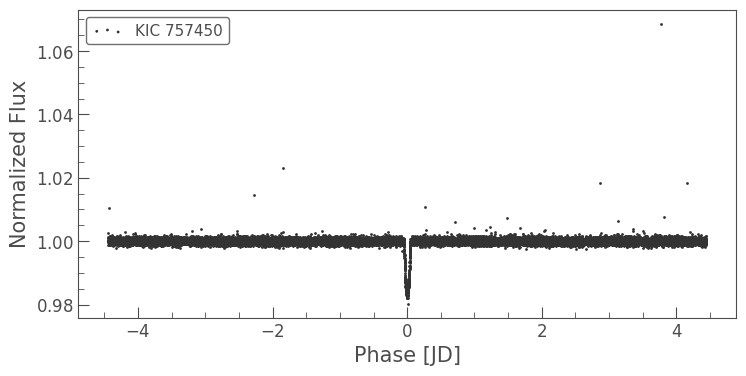

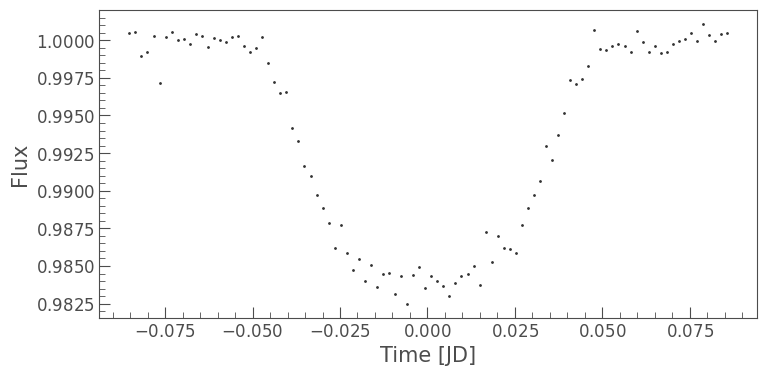

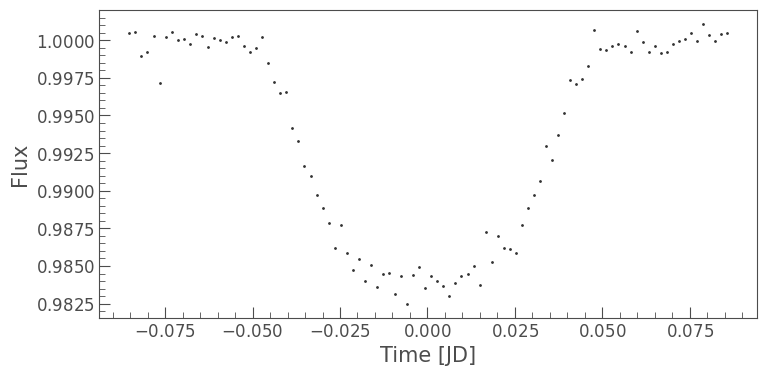

In [29]:
%matplotlib inline
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

kepid = 757450
curve_length = 100
df = pd.read_csv("midSet.csv")

row = df.loc[df["kepid"] == kepid]
period = row.iloc[0]["koi_period"]
t0 = row.iloc[0]["koi_time0bk"]
dur = row.iloc[0]["koi_duration"]

fractional_duration = (dur / 24.0) / period

print(row)

# test with KIC 757450 and 8672910 for confirmed, 9839062 is a cool FP that shows a secondary eclipse i think
lc = lk.search_lightcurve("KIC " + str(kepid), mission="Kepler", cadence = "long", limit = 6).download_all().stitch()
lc = lc.remove_nans()
# lc.scatter()

lc_flat = lc.flatten()
# lc_flat.scatter()

lc_fold = lc_flat.fold(period, epoch_time=t0)
lc_fold.scatter()

# How many full durations to include before/after mid-transit? (1 will include show the entire duration, 2 will show the duration and a bit more on the sides)
buffer_factor = 2

window_half_width = fractional_duration * buffer_factor
phase_mask = (lc_fold.phase > -(dur/24*0.5)*buffer_factor) & (lc_fold.phase < (dur/24*0.5)*buffer_factor)

lc_zoom = lc_fold[phase_mask]
# lc_zoom.scatter()

time = lc_zoom.time.value
flux = lc_zoom.flux.value

# Normalize time for interpolation
t_min, t_max = time.min(), time.max()
time_norm = (time - t_min) / (t_max - t_min)
new_time_norm = np.linspace(0, 1, curve_length)

# Interpolate flux to uniform time steps
new_flux = np.interp(new_time_norm, time_norm, flux)
new_time = np.linspace(t_min, t_max, curve_length)

int_lc = lk.LightCurve(time = new_time, flux = new_flux)
int_lc.scatter()

np.savez("testCurve/" + str(kepid) + ".npz", time=new_time, flux=new_flux)

data = np.load("testCurve/" + str(kepid) + ".npz")

time = data['time']
flux = data['flux']

lc_load = lk.LightCurve(time=time,flux=flux)
lc_load.scatter()

# print(len(int_lc))

Loading light curves...
Loaded 250 light curves.
Padding sequences...
200
Building model...
Training model...
Epoch 1/100


c:\Users\jarvi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.5086 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5903 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6107 - loss: 0.6744 - val_accuracy: 0.4600 - val_loss: 0.6890
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5620 - loss: 0.6622 - val_accuracy: 0.5000 - val_loss: 0.6676
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5565 - loss: 0.6643 - val_accuracy: 0.4800 - val_loss: 0.6756
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6288 - loss: 0.6990 - val_accuracy: 0.9200 - val_loss: 0.6282
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7007 - loss: 0.6300 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5653 - loss: 0.6606 - val_accuracy: 0.5000 - val_loss: 0.6

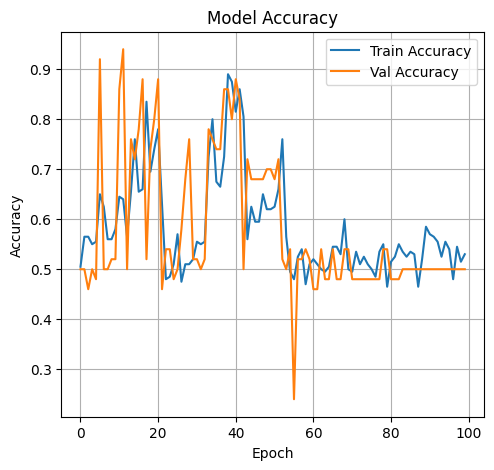

In [18]:
import os
import numpy as np
import pandas as pd
import lightkurve as lk
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === STEP 1: LOAD DATASET AND LABELS ===
df = pd.read_csv("midSet.csv")
label_map = {"CONFIRMED": 1, "FALSE POSITIVE": 0}

curve_length = 100

X = []
Y = []

print("Loading light curves...")
for _, row in df.iterrows():
    kepid = row["kepid"]
    label = label_map.get(row["koi_disposition"])

    data = np.load(f"curvesBig/{kepid}.npz")
    time = data["time"]
    flux = data["flux"]
    
    X.append(flux)
    Y.append(label)
    
print(f"Loaded {len(X)} light curves.")

# print(Y[0],X[0])

# # === STEP 2: PAD SEQUENCES ===
print("Padding sequences...")
X_padded = pad_sequences(X, maxlen=100, dtype='float32', padding='post')
X_padded = (X_padded - np.mean(X_padded)) / np.std(X_padded)
Y = np.array(Y)
X_input = X_padded[..., np.newaxis]  # Shape: (samples, timesteps, channels)

# print(X_input[6])

# # === STEP 3: TRAIN/VAL SPLIT ===
X_train, X_val, Y_train, Y_val = train_test_split(X_input, Y, test_size=0.2, random_state=42)

print(len(X_train))

# # === STEP 4: BUILD MODEL ===
print("Building model...")
model = Sequential([
    Masking(mask_value=0.0, input_shape=(curve_length, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional LSTM with more units
    Dropout(0.3),  # Dropout layer to prevent overfitting
    LSTM(64),      # Another LSTM layer to capture complex temporal patterns
    Dropout(0.3),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # === STEP 5: TRAIN MODEL ===
print("Training model...")

history = model.fit(
    X_train,         # shape: (num_samples, curve_length, 1)
    Y_train,         # shape: (num_samples,)
    epochs=100,       # change depending on how long you want to train
    batch_size=32,   # try 16 or 64 too
    validation_data=(X_val, Y_val),  # optional, but good for tracking overfitting
    verbose=1
)

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [19]:
import numpy as np
import os

# Define the directory where your .npz files are saved
npz_directory = 'curvesBig'  # Change this to the correct directory

# List all the .npz files
npz_files = [f for f in os.listdir(npz_directory) if f.endswith('.npz')]

# Loop through each file
for npz_file in npz_files:
    # Load the .npz file
    file_path = os.path.join(npz_directory, npz_file)
    data = np.load(file_path)

    # Extract time and flux arrays
    time = data['time']
    flux = data['flux']

    # Min-Max Scaling of the flux
    min_flux = np.min(flux)
    max_flux = np.max(flux)
    scaled_flux = (flux - min_flux) / (max_flux - min_flux)

    # Save the scaled flux values back into the same file (or a new file if you prefer)
    np.savez(os.path.join("curvesNorm/", npz_file), time=time, flux=scaled_flux)

    # Optionally, print progress
    print(f"Scaled flux values in {npz_file} and saved.")

Scaled flux values in 10005758.npz and saved.
Scaled flux values in 10023069.npz and saved.
Scaled flux values in 10031500.npz and saved.
Scaled flux values in 10098534.npz and saved.
Scaled flux values in 10123064.npz and saved.
Scaled flux values in 10132552.npz and saved.
Scaled flux values in 10139620.npz and saved.
Scaled flux values in 10187017.npz and saved.
Scaled flux values in 10264660.npz and saved.
Scaled flux values in 10268714.npz and saved.
Scaled flux values in 10351767.npz and saved.
Scaled flux values in 10386922.npz and saved.
Scaled flux values in 10399137.npz and saved.
Scaled flux values in 10427700.npz and saved.
Scaled flux values in 10489206.npz and saved.
Scaled flux values in 10581918.npz and saved.
Scaled flux values in 10614158.npz and saved.
Scaled flux values in 10616679.npz and saved.
Scaled flux values in 10729472.npz and saved.
Scaled flux values in 10748390.npz and saved.
Scaled flux values in 10795103.npz and saved.
Scaled flux values in 10847907.npz

<Axes: xlabel='Time [JD]', ylabel='Flux'>

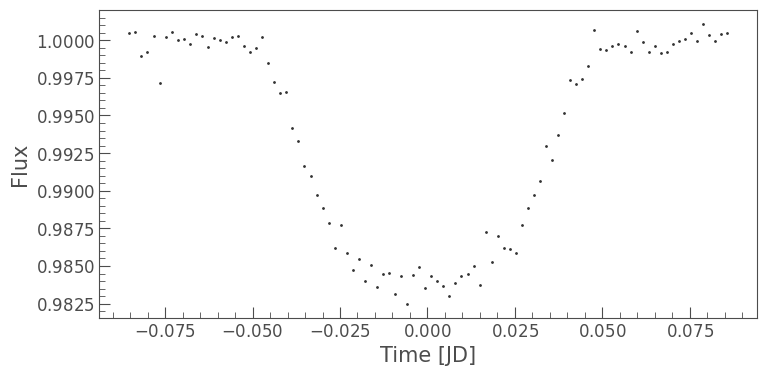

In [35]:
%matplotlib inline
import lightkurve as lk
import numpy as np

# 6387887
# 757450
kepid = 6387887
curve = np.load("curvesNorm/" + str(kepid) + ".npz")

time = data['time']
flux = data['flux']

lc = lk.LightCurve(time=time,flux=flux)
lc.scatter()